In [3]:
from sklearn.datasets import fetch_20newsgroups# news dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
categories = ['alt.atheism', 'sci.space', 'comp.graphics', 'rec.sport.hockey']#classes in dataset
newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups

{'data': [' \n My poor old physics intuition will be very surprised if these tiny\n masses, sitting very close to Jupiter, play any role whatsoever in the\n problem.   Or, to put it more technically, the extra "volume" they add\n to the phase space of possible capture trajectories is negligible.\n \n Jupiter is 2E27 kg, while the Galilean satellites are around 1E23.\n \n Also, as I said, the few references that I\'ve looked at do not\n mention outgassing or breakup as important processes.  The important\n thing is a Jupiter-Sun-comet "reverse slingshot" that leads to a\n weakly Jupiter-bound orbit for the comet (at least a temporary one).',
  '\n: >In fact, the tradition has been passed down to their affiliate\n: >in Adirondack. In Gm 6 of last yr\'s finals, an 8 legged creature was\n: >hurled onto the frozen pond and landed right at the feet of ref\n: >Lance Roberts.\n\n: It may have been passed to Toronto, but I\'ve even seen an octopus at\n: the Aud -- last year\'s Bruins-Sabres gam

In [5]:
newsgroups.target_names

['alt.atheism', 'comp.graphics', 'rec.sport.hockey', 'sci.space']

In [6]:
#newsgroups.target
print(f"Number of labels: {len(newsgroups.target)}")

Number of labels: 3758


In [7]:
texts = newsgroups.data
labels = newsgroups.target_names
labels


['alt.atheism', 'comp.graphics', 'rec.sport.hockey', 'sci.space']

In [8]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
labels

array([0, 1, 2, 3], dtype=int64)

In [9]:
print(f"Number of texts: {len(texts)}")
print(f"Number of labels: {len(labels)}")

Number of texts: 3758
Number of labels: 4


In [10]:
labels=newsgroups.target
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)


max_vocab_size = 10000 #max features to be input dimesions
max_sequence_length = 200 # Maximum length of input sequences

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

train_sequences = tokenizer.texts_to_sequences(train_texts)# text to numericsl values array
val_sequences = tokenizer.texts_to_sequences(val_texts)#text to numerical values array

train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding="post", truncating="post")
val_padded = pad_sequences(val_sequences, maxlen=max_sequence_length, padding="post", truncating="post")

In [11]:
import tensorflow as tf
###Using OOV buckets allows for easier and more stable handling of 
###previously unseen data during inference, making models more resilient to deployment environments.
def create_lookup_table(vocabulary, num_oov_buckets):
    keys_tensor = tf.constant(vocabulary)
    values_tensor = tf.constant(list(range(len(vocabulary))), dtype=tf.int64)

    initializer = tf.lookup.KeyValueTensorInitializer(keys_tensor, values_tensor)
    table = tf.lookup.StaticVocabularyTable(initializer, num_oov_buckets)
    return table


vocabulary = ['hello', 'world', 'tensorflow'] # Define our vocabulary and OOV bucket size
oov_bucket_size = 2

lookup_table = create_lookup_table(vocabulary, oov_bucket_size)

def transform_text_to_indices(text_tokens, lookup_table):
    indices = lookup_table.lookup(tf.constant(text_tokens))
    return indices
text = ['hello', 'wonderful', 'tensorflow', 'AI','MSOFFICE']
indices = transform_text_to_indices(text, lookup_table)
print(indices)

tf.Tensor([0 3 2 3 4], shape=(5,), dtype=int64)


In [12]:
print(lookup_table)

In [13]:
text = ['hello', 'wonderful', 'tensorflow', 'AI']
lookup_table.lookup(tf.constant(text)).numpy()

array([0, 3, 2, 3], dtype=int64)

In [14]:
vocabulary_map = {word: idx for idx, word in enumerate(vocabulary)}
oov_buckets = range(len(vocabulary), len(vocabulary) + oov_bucket_size)

print("Vocabulary Mapping:")
for word, idx in vocabulary_map.items():
    print(f"{word}: {idx}")

print("\nOOV Buckets:")
for bucket in oov_buckets:
    print(f"OOV Bucket {bucket}")


Vocabulary Mapping:
hello: 0
world: 1
tensorflow: 2

OOV Buckets:
OOV Bucket 3
OOV Bucket 4


In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
embedding_dim = 50
num_filters = 64
kernel_size = 3
dropout_rate = 0.5

model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(128, activation="relu"),
    Dropout(dropout_rate),
    Dense(num_classes, activation="softmax")  # Output layer for multiclass classification
])

model.compile( optimizer="adam",loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 50)           500000    
                                                                 
 conv1d (Conv1D)             (None, 198, 64)           9664      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                        

In [16]:

history = model.fit(
    train_padded,
    train_labels,
    validation_data=(val_padded, val_labels),
    epochs=12,
    batch_size=32
)


Epoch 1/12
94/94 [==============================] - 26s 50ms/step - loss: 1.3632 - accuracy: 0.3400 - val_loss: 1.2863 - val_accuracy: 0.4960
Epoch 2/12
94/94 [==============================] - 2s 17ms/step - loss: 0.8768 - accuracy: 0.6860 - val_loss: 0.6112 - val_accuracy: 0.8032
Epoch 3/12
94/94 [==============================] - 2s 18ms/step - loss: 0.3689 - accuracy: 0.8859 - val_loss: 0.4202 - val_accuracy: 0.8418
Epoch 4/12
94/94 [==============================] - 2s 19ms/step - loss: 0.1613 - accuracy: 0.9601 - val_loss: 0.3790 - val_accuracy: 0.8577
Epoch 5/12
94/94 [==============================] - 2s 19ms/step - loss: 0.0839 - accuracy: 0.9744 - val_loss: 0.3753 - val_accuracy: 0.8697
Epoch 6/12
94/94 [==============================] - 2s 18ms/step - loss: 0.0565 - accuracy: 0.9814 - val_loss: 0.3953 - val_accuracy: 0.8723
Epoch 7/12
94/94 [==============================] - 2s 18ms/step - loss: 0.0492 - accuracy: 0.9800 - val_loss: 0.4007 - val_accuracy: 0.8750
Epoch 8/12
9

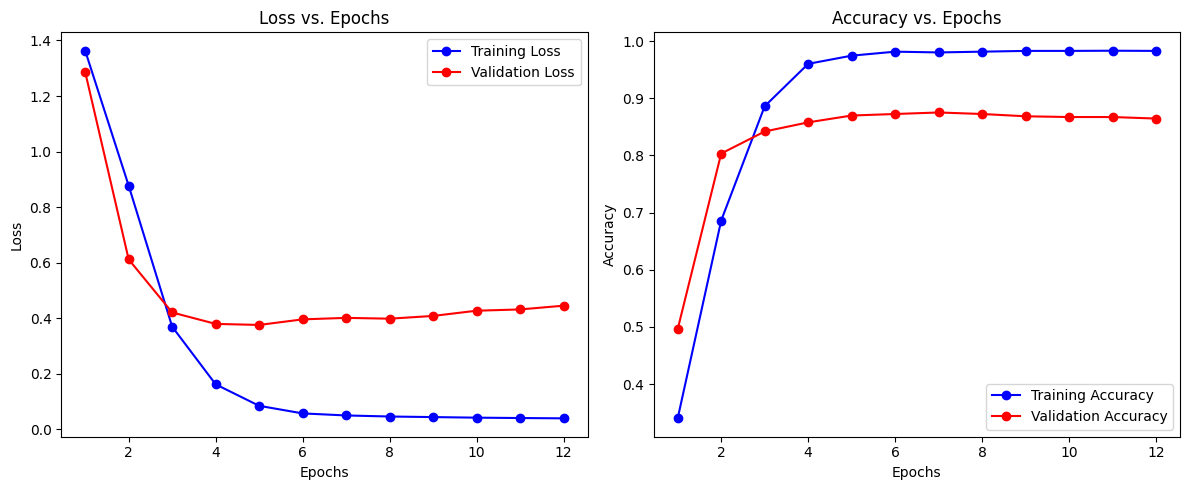

In [17]:
import matplotlib.pyplot as plt

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
epochs = range(1, len(val_loss) + 1)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
loss, accuracy = model.evaluate(val_padded, val_labels)
print(f"Validation Accuracy: {accuracy:.2f}")

24/24 [==============================] - 0s 12ms/step - loss: 0.4446 - accuracy: 0.8644
Validation Accuracy: 0.86


In [19]:

new_texts = [
    "The space shuttle launched successfully into orbit.",
    "I just installed a new graphics card in my computer.",
    "Hockey is an amazing sport to watch live.",
    "There are no proofs of God's existence."
]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding="post", truncating="post")

predictions = model.predict(new_padded)
predicted_labels = predictions.argmax(axis=1)#returns index of max value in array
print("Predicted Labels:", label_encoder.inverse_transform(predicted_labels))

1/1 [==============================] - 1s 1s/step
Predicted Labels: ['sci.space' 'comp.graphics' 'rec.sport.hockey' 'alt.atheism']


In [20]:
model.save("cnn_multiclass_text_classifier.h5")
from tensorflow.keras.models import load_model
loaded_model = load_model("cnn_multiclass_text_classifier.h5")#inferencing
#new_sequences = tokenizer.texts_to_sequences(new_texts)
#new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding="post", truncating="post")

loaded_predictions = loaded_model.predict(new_padded)
loaded_predicted_labels = loaded_predictions.argmax(axis=1)
print("Loaded Model Predictions:", label_encoder.inverse_transform(loaded_predicted_labels))


1/1 [==============================] - 0s 62ms/step
Loaded Model Predictions: ['sci.space' 'comp.graphics' 'rec.sport.hockey' 'alt.atheism']


In [22]:
predictions = model.predict(new_padded)
predictions

1/1 [==============================] - 0s 31ms/step


array([[6.1142622e-08, 1.2524749e-08, 5.8240221e-07, 9.9999928e-01],
       [5.2390862e-11, 1.0000000e+00, 2.5309581e-12, 8.0102049e-09],
       [2.2149554e-03, 4.0581115e-03, 9.7369927e-01, 2.0027617e-02],
       [9.0110594e-01, 5.4380674e-02, 2.8896600e-03, 4.1623641e-02]],
      dtype=float32)

In [23]:
predictions.argmax(axis=1)

array([3, 1, 2, 0], dtype=int64)

In [26]:
['alt.atheism', 'comp.graphics', 'rec.sport.hockey', 'sci.space']
label_encoder.inverse_transform([3, 1, 2, 0])



array(['sci.space', 'comp.graphics', 'rec.sport.hockey', 'alt.atheism'],
      dtype='<U16')